# Reference

The original code can be found https://github.com/Lezcano/expRNN

This pythonnotebook concentrates on the implementation of the dynamic trivialization method over symplectic group.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import argparse
from torchvision import datasets, transforms
from torch.functional import F

import matplotlib.pyplot as plt

import sys
sys.argv=['']
del sys

# Notations
To be consistent with the thesis paper, in the following context, let's denote:

(1). $G = Sp(2n, \mathbb R) = \{A: A^TJA = J\}$, the symplectic group.

(2). $A \in G$, a symplectic matrix.

(3). $X \in \mathfrak{g} = sp(2n,\mathbb{R}) = \{X: (XJ)^T=(XJ)\}$, a matrix in the Lie algebra of $G$.

(4). $Y \in T_AG$, a matrix in the tangent space at $A$.

$A$ and $X$ will be used most of the time.

#Parameters
Under dynamic trivialization, in a general Neural Network combining Symplectic layers and Euclidean layers, we have two kinds of parameters. 

(1). The matrices $X$ in the Lie algebra $\mathfrak{g} \cong T_{e}G$ of the Symplectic layers. 

(2). The parameters $w$ of regular Euclidean layers.

In the following codes, the writer Lezcano denotes 

(1). symplectic Lie algebra matrix $X$ with 'parametrized_params' and 

(2). regular Euclidean parameters $w$ with 'unconstrained_params'.

If we simply want to test the optimization on symplectic group, we shall just use the 'LinearSymplectic' layer (find it below) to build up the test, i.e. we will only have the first kind of parameters $X$.

In [2]:
def get_parameters(model):
    parametrized_params = []

    def get_parametrized_params(mod):
        nonlocal parametrized_params
        if isinstance(mod, Parametrization):
            parametrized_params.append(mod.X)

    def not_in(elem, l):
        return all(elem is not x for x in l)

    model.apply(get_parametrized_params)

    unconstrained_params = (param for param in model.parameters() if not_in(param, parametrized_params))

    return unconstrained_params, parametrized_params

#Parametrization Class

The following build-up of Parametrization class is kept unchange from Lezcano's original code except the different denotings.

Notice that by calling .A, it will give the parametrized matrix $A$.


In [3]:

# Parametrization Class

class Parametrization(nn.Module):
    """
    Implements the parametrization of a manifold in terms of a Euclidean space
    It gives the parametrized matrix through the attribute `A`
    """

    def __init__(self, X, base, mode):
        """
        mode: "static" or a tuple such that:
                mode[0] == "dynamic"
                mode[1]: int, K, the number of steps after which we should change the basis of the dyn triv
                mode[2]: int, M, the number of changes of basis after which we should project back onto the manifold the basis. This is particularly helpful for small values of K.
        """
        super(Parametrization, self).__init__()
        assert mode == "static" or (isinstance(mode, tuple) and len(mode) == 3 and mode[0] == "dynamic")

        self.X = nn.Parameter(X)
        self.register_buffer("_A", None)
        self.register_buffer('base', base)
        # This is necessary, as it will be generated again the first time that self.A is called
        # We still need to register the buffer though

        if mode == "static":
            self.mode = mode
        else:
            self.mode = mode[0]
            self.K = mode[1]
            self.M = mode[2]
            self.k = 0
            self.m = 0

        # This implements the parametrization trick in a rather slick way.
        # We put a hook on X, such that, whenever its gradients are computed, we
        # get rid of self._A so that it has to be recomputed the next time that
        # self.A is accessed
        def hook(grad):
            nonlocal self
            self._A = None
        self.X.register_hook(hook)

    #change the base point
    def rebase(self):
        with torch.no_grad():
            self.base.data.copy_(self._A.data)
            self.X.data.zero_()

    @property
    def A(self):
        not_A = self._A is None
        if not_A or (not self._A.grad_fn and torch.is_grad_enabled()):
            self._A = self.retraction(self.X, self.base)
            # Just to be safe
            self._A.requires_grad_()
            # Now self._A it's not a leaf tensor, so we convert it into a leaf
            self._A.retain_grad()

            # Increment the counters for the dyntriv algorithm if we have generated A
            if self.mode == "dynamic" and not_A:
                if self.k == 0:
                    self.rebase()
                    # Project the base back to the manifold every M changes of base
                    # Increment the counter before as we don't project the first time
                    self.m = (self.m + 1) % self.M
                    # It's optional to implement this method
                    if self.m == 0 and hasattr(self, "project"):
                        with torch.no_grad():
                            self.base = self.project(self.base)
                # Change the basis after K optimization steps
                # Increment the counter afterwards as we change the basis in the first iteration
                if self.K != "infty":
                    self.k = (self.k + 1) % self.K
                else:
                    # Make sure that we just update the base once
                    if self.k == 0:
                        self.k = 1
        return self._A

    def retraction(self, X, base):
        """
        It computes r_{base}(X).
        Notice that X will not always be in the tangent space of our manifold
          For this reason, we first have to use X to parametrize the tangent space,
          and then compute the retraction
        When dealing with Lie groups, raw_X is always projected into the Lie algebra, as an optimization (cf. Section E in the paper)
        """
        raise NotImplementedError

    def project(self, base):
        """
        This method is OPTIONAL
        It returns the projected base back into the manifold
        """
        raise NotImplementedError

    def forward(self, input):
        """
        It uses the attribute self.A to implement the layer itself (e.g. Linear, CNN, ...)
        """
        raise NotImplementedError


#Linear Symplectic Layer

This is a simple Linear Symplectic layer.

Input: vector/matrix $v$.

operateion: left multiplication, i.e. $vA$, where $A \in Sp(2n,\mathbb R)$

output: $vA$

(Notice that the function "forward" can be rewritten to produce any other desired structure. In our simple test of optimization, here we just use a very simple linear structure with no bias.)

As the comment of "retraction" in the above Parametrization class, we would expect $X$ to be in $sp(2n, \mathbb{R}) = \{JX+X^TJ = 0\}$. 

Note that for any $Y \in T_AG$, 
\begin{align*}
    \exp_A: T_A G &\to G\\
                Y &\mapsto A\exp(A^{-1}Y) 
\end{align*}

and $T_AG = \{AX: X \in \mathfrak{g}\}$, i.e. $Y = AX$ for some $X \in sp(2n,\mathbb{R})$

Therefore, 
$$\exp_A(Y) = A\exp(A^{-1}Y) = A\exp(A^{-1}AX) = A\exp(X)$$
for $X \in sp(2n,\mathbb{R})$. 

This means that if given A and a parametrization of $sp(2n, \mathbb{R})$, we can calculate the exponential map.

To parametrize $sp(2n,\mathbb{R})$, first notice that 
\begin{align*}
    sp(2n,\mathbb{R}) &= \{X: JX+X^TJ = 0\}\\
                      &= \{X: JX-X^TJ^T = 0\}\\
                      &= \{X: JX-(JX)^T = 0\}\\
                      &= \{X: JX=(JX)^T\}
\end{align*}

So we can first make $JX$ into symmetric matrix and then left multiply $J^{-1} = J^T$ to parametrize $X$, and thus do the parametrization.

In [4]:
#LinearSymplectic

class LinearSymplectic(Parametrization):
    #input a vector/matrix v, left multiply with symplectic matrix B
    #and output the vector/matrix vB.
    def __init__(self, size, mode, param):
        """
        mode: in our case we would like to use dynamic trivialization, so:
                mode[0] == "dynamic"
                mode[1]: int, K, the number of steps after which we should change the basis of the dyn triv
                mode[2]: int, M, the number of changes of basis after which we should project back onto the manifold the basis. 
                          This is particularly helpful for small values of K.
                          (this parameter has no influence when K)
        param: X parametrization in terms of symplectic matrices
        """

        if size % 2 != 0:
            raise ValueError("Symplectic group is supposed to have size 2n.")

        #initialize
        X = torch.empty(size, size)
        base = torch.empty(size, size)

        super(LinearSymplectic, self).__init__(X, base, mode)
        self.size = size
        self.param = param
        self.init_base = nn.init.eye_
        self.init_X = nn.init.zeros_
        self.reset_parameters()

        #set the matrix J of Sp(2n,R)
        n = self.size //2 
        zero = torch.zeros(n,n)
        neg_one = torch.tensor([-1.0 for i in range(n)])
        pos_one = torch.tensor([1.0 for i in range(n)])
        neg_I = torch.diag(neg_one)
        pos_I = torch.diag(pos_one)
        J1 = torch.hstack((zero,pos_I))
        J2 = torch.hstack((neg_I,zero))
        self.J = torch.vstack((J1,J2))

    def reset_parameters(self):
        self.init_X(self.X)
        self.init_base(self.base)
        

    def forward(self, input):
        #this function can be rewritten to produce any other desired structure
        #in our simple test of optimization, here we just use a very simple linear structure with no bias.
        return input.matmul(self.A)

    def retraction(self, X, base):
        #make sure JX is symmetric so that X is in Lie algebra of symplectic group.
        X = (X + X.t())/2
        X = self.J.mm(X)
        A = base.mm(self.param(X)) 
        return A

    def retraction2(self, X, base):
        #make sure JX is symmetric so that X is in Lie algebra of symplectic group.
        #The retraction map is not unique. Any parametrization that makes X in the the Lie algebra can work.
        #The one below is another retraction for symplectic group.
        JX = self.J.mm(X)
        JX = (JX+JX.t())/2
        X = self.J.t().mm(JX)
        A = base.mm(self.param(X))
        return A
        
    
    
    

#Trivialization

Here we shall just put emphasis on the expm class.

In [5]:
# trivializations

def cayley_map(A):
    n = A.size(0)
    Id = torch.eye(n, dtype=X.dtype, device=A.device)
    return torch.solve(Id - A, Id + A)[0]

class expm_class(torch.autograd.Function):
    @staticmethod
    def forward(ctx, X):
        ctx.save_for_backward(X)
        return expm32(X)

    @staticmethod
    def backward(ctx, G):
        (X,) = ctx.saved_tensors
        return differential(expm32, X.t(), G)

expm = expm_class.apply

# Matrix Exponential and the Differential

'expm32' calculates the matrix exponential.

'differential' computes the differential of $f$ at $A$ when acting on $E$: $(df)_A(E)$



In [6]:
# matrx exponential and differential 

"""
Adaptation of expm and expm_frechet in numpy for torch
"""

#
# Authors: Travis Oliphant, March 2002
#          Anthony Scopatz, August 2012 (Sparse Updates)
#          Jake Vanderplas, August 2012 (Sparse Updates)
#

from __future__ import division, print_function, absolute_import

import math

import numpy as np

import torch
import scipy.special

def _onenorm_matrix_power_nnm(A, p):
    """
    Compute the 1-norm of a non-negative integer power of a non-negative matrix.
    Parameters
    ----------
    A : a square ndarray or matrix or sparse matrix
        Input matrix with non-negative entries.
    p : non-negative integer
        The power to which the matrix is to be raised.
    Returns
    -------
    out : float
        The 1-norm of the matrix power p of A.
    """
    # check input
    if int(p) != p or p < 0:
        raise ValueError('expected non-negative integer p')
    p = int(p)
    if len(A.shape) != 2 or A.shape[0] != A.shape[1]:
        raise ValueError('expected A to be like a square matrix')

    # Explicitly make a column vector so that this works when A is a
    # numpy matrix (in addition to ndarray and sparse matrix).
    v = torch.ones((A.shape[0], 1), dtype=A.dtype, device=A.device)
    M = A.t()
    for _ in range(p):
        v = M.mm(v)
    return torch.max(v).item()


def _onenorm(A):
    return torch.norm(A, 1).item()


def _ident_like(A):
    return torch.eye(A.shape[0], A.shape[1], dtype=A.dtype, device=A.device)

class _ExpmPadeHelper(object):
    """
    Help lazily evaluate a matrix exponential.
    The idea is to not do more work than we need for high expm precision,
    so we lazily compute matrix powers and store or precompute
    other properties of the matrix.
    """
    def __init__(self, A):
        """
        Initialize the object.
        Parameters
        ----------
        A : a dense or sparse square numpy matrix or ndarray
            The matrix to be exponentiated.
        """
        self.A = A
        self._A2 = None
        self._A4 = None
        self._A6 = None
        self._A8 = None
        self._A10 = None
        self._d4_exact = None
        self._d6_exact = None
        self._d8_exact = None
        self._d10_exact = None
        self._d4_approx = None
        self._d6_approx = None
        self._d8_approx = None
        self._d10_approx = None
        self.ident = _ident_like(A)

    @property
    def A2(self):
        if self._A2 is None:
            self._A2 = self.A.mm(self.A)
        return self._A2

    @property
    def A4(self):
        if self._A4 is None:
            self._A4 = self.A2.mm(self.A2)
        return self._A4

    @property
    def A6(self):
        if self._A6 is None:
            self._A6 = self.A4.mm(self.A2)
        return self._A6

    @property
    def A8(self):
        if self._A8 is None:
            self._A8 = self.A6.mm(self.A2)
        return self._A8

    @property
    def A10(self):
        if self._A10 is None:
            self._A10 = self.A4.mm(self.A6)
        return self._A10

    @property
    def d4_tight(self):
        if self._d4_exact is None:
            self._d4_exact = _onenorm(self.A4)**(1/4.)
        return self._d4_exact

    @property
    def d6_tight(self):
        if self._d6_exact is None:
            self._d6_exact = _onenorm(self.A6)**(1/6.)
        return self._d6_exact

    @property
    def d8_tight(self):
        if self._d8_exact is None:
            self._d8_exact = _onenorm(self.A8)**(1/8.)
        return self._d8_exact

    @property
    def d10_tight(self):
        if self._d10_exact is None:
            self._d10_exact = _onenorm(self.A10)**(1/10.)
        return self._d10_exact

    @property
    def d4_loose(self):
        return self.d4_tight

    @property
    def d6_loose(self):
        return self.d6_tight

    @property
    def d8_loose(self):
        return self.d8_tight

    @property
    def d10_loose(self):
        return self.d10_tight

    def pade3(self):
        b = (120., 60., 12., 1.)
        U = self.A.mm(b[3]*self.A2 + b[1]*self.ident)
        V = b[2]*self.A2 + b[0]*self.ident
        return U, V

    def pade5(self):
        b = (30240., 15120., 3360., 420., 30., 1.)
        U = self.A.mm(b[5]*self.A4 + b[3]*self.A2 + b[1]*self.ident)
        V = b[4]*self.A4 + b[2]*self.A2 + b[0]*self.ident
        return U, V

    def pade7_scaled(self, s):
        b = (17297280., 8648640., 1995840., 277200., 25200., 1512., 56., 1.)

        B = self.A * 2**-s
        B2 = self.A2 * 2**(-2*s)
        B4 = self.A4 * 2**(-4*s)
        B6 = self.A6 * 2**(-6*s)

        U = B.mm(b[7]*B6 + b[5]*B4 + b[3]*B2 + b[1]*self.ident)
        V = b[6]*B6 + b[4]*B4 + b[2]*B2 + b[0]*self.ident
        return U, V


def expm32(A):
    """
    Compute the matrix exponential using Pade approximation.
    Parameters
    ----------
    A : (M,M) array_like or sparse matrix
        2D Array or Matrix (sparse or dense) to be exponentiated
    Returns
    -------
    expA : (M,M) ndarray
        Matrix exponential of `A`
    Notes
    -----
    This is algorithm (6.1) which is a simplification of algorithm (5.1).
    .. versionadded:: 0.12.0
    References
    ----------
    .. [1] Awad H. Al-Mohy and Nicholas J. Higham (2009)
           "A New Scaling and Squaring Algorithm for the Matrix Exponential."
           SIAM Journal on Matrix Analysis and Applications.
           31 (3). pp. 970-989. ISSN 1095-7162
    """
    return _expm(A)


def _expm(A):
    # Core of expm, separated to allow testing exact and approximate
    # algorithms.

    # Avoid indiscriminate asarray() to allow sparse or other strange arrays.
    if len(A.shape) != 2 or A.shape[0] != A.shape[1]:
        raise ValueError('expected a square matrix')

    # Trivial case
    if A.shape == (1, 1):
        return torch.exp(A)

    # Track functions of A to help compute the matrix exponential.
    h = _ExpmPadeHelper(A)

    # Try Pade order 3.
    eta_1 = max(h.d4_loose, h.d6_loose)
    theta3 = 4.2587300348979312e-001
    if eta_1 < theta3 and _ell(h.A, 3) == 0:
        U, V = h.pade3()
        return _solve_P_Q(U, V)

    # Try Pade order 5.
    eta_2 = max(h.d4_tight, h.d6_loose)
    theta5 = 1.8801526985337688e+000
    if eta_2 < theta5 and _ell(h.A, 5) == 0:
        U, V = h.pade5()
        return _solve_P_Q(U, V)

    theta_7 = 3.9257248464332842e+000
    eta_3 = max(h.d6_tight, h.d8_loose)
    s = max(int(np.ceil(np.log2(eta_3 / theta_7))), 0)

    s += _ell(2**-s * h.A, 7)
    U, V = h.pade7_scaled(s)
    X = _solve_P_Q(U, V)
    return torch.matrix_power(X, 2**s)


def _solve_P_Q(U, V):
    P = U + V
    Q = -U + V
    return torch.linalg.solve(P, Q)


def _ell(A, m):
    """
    A helper function for expm_2009.
    Parameters
    ----------
    A : linear operator
        A linear operator whose norm of power we care about.
    m : int
        The power of the linear operator
    Returns
    -------
    value : int
        A value related to a bound.
    """
    if len(A.shape) != 2 or A.shape[0] != A.shape[1]:
        raise ValueError('expected A to be like a square matrix')

    p = 2*m + 1

    # The c_i are explained in (2.2) and (2.6) of the 2005 expm paper.
    # They are coefficients of terms of a generating function series expansion.
    choose_2p_p = scipy.special.comb(2*p, p, exact=True)
    abs_c_recip = float(choose_2p_p * math.factorial(2*p + 1))

    # This is explained after Eq. (1.2) of the 2009 expm paper.
    # It is the "unit roundoff" of IEEE double precision arithmetic.
    u = 2.**-24

    # Compute the one-norm of matrix power p of abs(A).
    A_abs_onenorm = _onenorm_matrix_power_nnm(abs(A), p)

    # Treat zero norm as a special case.
    if not A_abs_onenorm:
        return 0

    alpha = A_abs_onenorm / (_onenorm(A) * abs_c_recip)
    return max(int(np.ceil(np.log2(alpha/u) / (2 * m))), 0)

def differential(f, A, E):
    """ Computes the differential of f at A when acting on E:  (df)_A(E) """
    n = A.size(0)
    M = torch.zeros(2*n, 2*n, dtype=A.dtype, device=A.device, requires_grad=False)
    M[:n, :n] = A
    M[n:, n:] = A
    M[:n, n:] = E
    return f(M)[:n, n:]

# Simple Test(Vanilla)

We first generate a fixed symplectic matrix $G$. Then we generated some random vectors $v$. Through a right multiplication by $G$, we also generate the labels $y = vG$.

Now we feed the generated $v$ and $y$ into the LinearSymplectic layer and train the model. Thus the optimization problem is 
$$
\min\limits_{A \in Sp(2n,\mathbb{R})}\mathbb{E}[||vA-y||^2]
$$
where $||.||$ is the vector norm.

The exact solution should be the G we created, and we expect the result to be close to G.

##Defalut setting, K=10, vanilla epoch 3000, batch epoch 300, learning rate 0.05

In [7]:
# test_main
parser = argparse.ArgumentParser(description='Linear Symplectic Layer Simple Task')
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--hidden_size', type=int, default=170)
parser.add_argument('--epochs', type=int, default=3000)
parser.add_argument('--epochs2', type=int, default=3000)
parser.add_argument('--lr', type=float, default=1e-2)
parser.add_argument('--lr_symp', type=float, default=5e-2)
parser.add_argument("--permute", action="store_true")
parser.add_argument("-m", "--mode",
                    choices=["exprnn", "dtriv", "cayley", "lstm"],
                    default="dtriv",
                    type=str)
parser.add_argument('--K', type=str, default="10", help='The K parameter in the dtriv algorithm. It should be a positive integer or "infty".')


args = parser.parse_args()

batch_size  = args.batch_size
hidden_size = args.hidden_size
epochs      = args.epochs
epochs2 = args.epochs2
device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


if args.K != "infty":
    args.K = int(args.K)

if args.mode == "exprnn":
    mode = "static"
    param = expm

elif args.mode == "dtriv":
    # We use 100 as the default to project back to the manifold.
    # This parameter does not really affect the convergence of the algorithms, even for K=1
    mode = ("dynamic", args.K, 10000)
    param = expm
    
elif args.mode == "cayley":
    mode = "static"
    param = cayley_map

## Data

In [8]:
input_size = 4
np.random.seed(0)

G = [[ 1.,   3.,   1.,   0. ],
     [ 2.,   4., -2.5,  1.5],
     [ 0.,   0.,  -2.,   1. ],
     [ 0.,   0.,   1.5, -0.5]]

n = 1000

V = []
y = []
for i in range(n):
    v = np.random.rand(4) 
    V.append(v)
    y.append(v.dot(G) )


##Comparison on different K

###Test Model 1, default K=10

In [9]:
losses_1 = []
class test_Model(nn.Module):
    def __init__(self, input_size):
        super(test_Model, self).__init__()
        self.symp = LinearSymplectic(input_size, mode=mode, param=param)
        #self.lin = nn.Linear(input_size, input_size)
        self.J = self.symp.J
        self.loss_func = nn.MSELoss()

    def forward(self, input): 
        l = self.symp(input)
        return l

    def loss(self, preds, y):
        return self.loss_func(preds, y)

def main():
    model = test_Model(input_size).to(device)
    model.train()
    non_symp_params, log_symp_params = get_parameters(model)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=args.lr_symp)
    for epoch in range(3000):
        preds = model(torch.tensor(V).float())
        loss = model.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        losses_1.append(loss)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))
        #print(model.symp.A)
        
    print("Optimization Finished!")
    model.eval()
    print("The resulted symplectic matrix is:")
    print(model.symp.A)


if __name__ == "__main__":
    main()

Iter 0: Loss= 4.166244
Iter 1: Loss= 3.878474
Iter 2: Loss= 3.597948
Iter 3: Loss= 3.324289
Iter 4: Loss= 3.056826
Iter 5: Loss= 2.794142
Iter 6: Loss= 2.534151
Iter 7: Loss= 2.275515
Iter 8: Loss= 2.019655
Iter 9: Loss= 1.771784
Iter 10: Loss= 1.541022
Iter 11: Loss= 1.344222
Iter 12: Loss= 1.162010
Iter 13: Loss= 0.995252
Iter 14: Loss= 0.848957
Iter 15: Loss= 0.732706
Iter 16: Loss= 0.656703
Iter 17: Loss= 0.626719
Iter 18: Loss= 0.640306
Iter 19: Loss= 0.685938
Iter 20: Loss= 0.745867
Iter 21: Loss= 0.811995
Iter 22: Loss= 0.842381
Iter 23: Loss= 0.824648
Iter 24: Loss= 0.776047
Iter 25: Loss= 0.721130
Iter 26: Loss= 0.676258
Iter 27: Loss= 0.646068
Iter 28: Loss= 0.627677
Iter 29: Loss= 0.616115
Iter 30: Loss= 0.608371
Iter 31: Loss= 0.606205
Iter 32: Loss= 0.609433
Iter 33: Loss= 0.615904
Iter 34: Loss= 0.622079
Iter 35: Loss= 0.624937
Iter 36: Loss= 0.623577
Iter 37: Loss= 0.619252
Iter 38: Loss= 0.614183
Iter 39: Loss= 0.610095
Iter 40: Loss= 0.607241
Iter 41: Loss= 0.604506
It

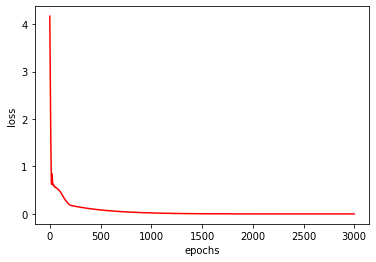

In [10]:
plt.plot(losses_1,'r')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

###Test Model 2, K=50

In [11]:
losses_2 = []
class test_Model_2(nn.Module):
    def __init__(self, input_size):
        super(test_Model_2, self).__init__()
        self.symp = LinearSymplectic(input_size, mode=("dynamic", 50, 10000), param=param)
        #self.lin = nn.Linear(input_size, input_size)
        self.J = self.symp.J
        self.loss_func = nn.MSELoss()

    def forward(self, input): 
        l = self.symp(input)
        #l = self.lin(l)
        return l

    def loss(self, preds, y):
        return self.loss_func(preds, y)

def main():
    model = test_Model_2(input_size).to(device)
    model.train()
    non_symp_params, log_symp_params = get_parameters(model)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=args.lr_symp)
    for epoch in range(epochs):
        preds = model(torch.tensor(V).float())
        loss = model.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        
        losses_2.append(loss)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))
        #print(model.symp.A)

    print("Optimization Finished!")
    model.eval()
    print("The resulted symplectic matrix is:")
    print(model.symp.A)

if __name__ == "__main__":
    main()

Iter 0: Loss= 4.166244
Iter 1: Loss= 3.878474
Iter 2: Loss= 3.597948
Iter 3: Loss= 3.324289
Iter 4: Loss= 3.056826
Iter 5: Loss= 2.794142
Iter 6: Loss= 2.534151
Iter 7: Loss= 2.275515
Iter 8: Loss= 2.019655
Iter 9: Loss= 1.771784
Iter 10: Loss= 1.541022
Iter 11: Loss= 1.339745
Iter 12: Loss= 1.180507
Iter 13: Loss= 1.068279
Iter 14: Loss= 0.994794
Iter 15: Loss= 0.944403
Iter 16: Loss= 0.901493
Iter 17: Loss= 0.855470
Iter 18: Loss= 0.802750
Iter 19: Loss= 0.745865
Iter 20: Loss= 0.691310
Iter 21: Loss= 0.646658
Iter 22: Loss= 0.617660
Iter 23: Loss= 0.606302
Iter 24: Loss= 0.610424
Iter 25: Loss= 0.624792
Iter 26: Loss= 0.642967
Iter 27: Loss= 0.659132
Iter 28: Loss= 0.669245
Iter 29: Loss= 0.671375
Iter 30: Loss= 0.665453
Iter 31: Loss= 0.652745
Iter 32: Loss= 0.635291
Iter 33: Loss= 0.615398
Iter 34: Loss= 0.595234
Iter 35: Loss= 0.576526
Iter 36: Loss= 0.560363
Iter 37: Loss= 0.547142
Iter 38: Loss= 0.536656
Iter 39: Loss= 0.528307
Iter 40: Loss= 0.521377
Iter 41: Loss= 0.515267
It

###Test Model 3, K=100

In [12]:
losses_3 = []
class test_Model_3(nn.Module):
    def __init__(self, input_size):
        super(test_Model_3, self).__init__()
        self.symp = LinearSymplectic(input_size, mode=("dynamic", 100, 10000), param=param)
        #self.lin = nn.Linear(input_size, input_size)
        self.J = self.symp.J
        self.loss_func = nn.MSELoss()

    def forward(self, input): 
        l = self.symp(input)
        #l = self.lin(l)
        return l

    def loss(self, preds, y):
        return self.loss_func(preds, y)

def main():
    model = test_Model_3(input_size).to(device)
    model.train()
    non_symp_params, log_symp_params = get_parameters(model)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=args.lr_symp)
    for epoch in range(epochs):
        preds = model(torch.tensor(V).float())
        loss = model.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        
        losses_3.append(loss)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))
        #print(model.symp.A)

    print("Optimization Finished!")
    model.eval()
    print("The resulted symplectic matrix is:")
    print(model.symp.A)

if __name__ == "__main__":
    main()

Iter 0: Loss= 4.166244
Iter 1: Loss= 3.878474
Iter 2: Loss= 3.597948
Iter 3: Loss= 3.324289
Iter 4: Loss= 3.056826
Iter 5: Loss= 2.794142
Iter 6: Loss= 2.534151
Iter 7: Loss= 2.275515
Iter 8: Loss= 2.019655
Iter 9: Loss= 1.771784
Iter 10: Loss= 1.541022
Iter 11: Loss= 1.339745
Iter 12: Loss= 1.180507
Iter 13: Loss= 1.068279
Iter 14: Loss= 0.994794
Iter 15: Loss= 0.944403
Iter 16: Loss= 0.901493
Iter 17: Loss= 0.855470
Iter 18: Loss= 0.802750
Iter 19: Loss= 0.745865
Iter 20: Loss= 0.691310
Iter 21: Loss= 0.646658
Iter 22: Loss= 0.617660
Iter 23: Loss= 0.606302
Iter 24: Loss= 0.610424
Iter 25: Loss= 0.624792
Iter 26: Loss= 0.642967
Iter 27: Loss= 0.659132
Iter 28: Loss= 0.669245
Iter 29: Loss= 0.671375
Iter 30: Loss= 0.665453
Iter 31: Loss= 0.652745
Iter 32: Loss= 0.635291
Iter 33: Loss= 0.615398
Iter 34: Loss= 0.595234
Iter 35: Loss= 0.576526
Iter 36: Loss= 0.560363
Iter 37: Loss= 0.547142
Iter 38: Loss= 0.536656
Iter 39: Loss= 0.528307
Iter 40: Loss= 0.521377
Iter 41: Loss= 0.515267
It

###Test Model 4, K=300

In [13]:
losses_4 = []
class test_Model_4(nn.Module):
    def __init__(self, input_size):
        super(test_Model_4, self).__init__()
        self.symp = LinearSymplectic(input_size, mode=("dynamic", 300, 10000), param=param)
        #self.lin = nn.Linear(input_size, input_size)
        self.J = self.symp.J
        self.loss_func = nn.MSELoss()

    def forward(self, input): 
        l = self.symp(input)
        #l = self.lin(l)
        return l

    def loss(self, preds, y):
        return self.loss_func(preds, y)

def main():
    model = test_Model_4(input_size).to(device)
    model.train()
    non_symp_params, log_symp_params = get_parameters(model)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=args.lr_symp)
    for epoch in range(epochs):
        preds = model(torch.tensor(V).float())
        loss = model.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        
        losses_4.append(loss)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))
        #print(model.symp.A)

    print("Optimization Finished!")
    model.eval()
    print("The resulted symplectic matrix is:")
    print(model.symp.A)

if __name__ == "__main__":
    main()

Iter 0: Loss= 4.166244
Iter 1: Loss= 3.878474
Iter 2: Loss= 3.597948
Iter 3: Loss= 3.324289
Iter 4: Loss= 3.056826
Iter 5: Loss= 2.794142
Iter 6: Loss= 2.534151
Iter 7: Loss= 2.275515
Iter 8: Loss= 2.019655
Iter 9: Loss= 1.771784
Iter 10: Loss= 1.541022
Iter 11: Loss= 1.339745
Iter 12: Loss= 1.180507
Iter 13: Loss= 1.068279
Iter 14: Loss= 0.994794
Iter 15: Loss= 0.944403
Iter 16: Loss= 0.901493
Iter 17: Loss= 0.855470
Iter 18: Loss= 0.802750
Iter 19: Loss= 0.745865
Iter 20: Loss= 0.691310
Iter 21: Loss= 0.646658
Iter 22: Loss= 0.617660
Iter 23: Loss= 0.606302
Iter 24: Loss= 0.610424
Iter 25: Loss= 0.624792
Iter 26: Loss= 0.642967
Iter 27: Loss= 0.659132
Iter 28: Loss= 0.669245
Iter 29: Loss= 0.671375
Iter 30: Loss= 0.665453
Iter 31: Loss= 0.652745
Iter 32: Loss= 0.635291
Iter 33: Loss= 0.615398
Iter 34: Loss= 0.595234
Iter 35: Loss= 0.576526
Iter 36: Loss= 0.560363
Iter 37: Loss= 0.547142
Iter 38: Loss= 0.536656
Iter 39: Loss= 0.528307
Iter 40: Loss= 0.521377
Iter 41: Loss= 0.515267
It

###Test Model 5, K=500

In [14]:
losses_5 = []
class test_Model_5(nn.Module):
    def __init__(self, input_size):
        super(test_Model_5, self).__init__()
        self.symp = LinearSymplectic(input_size, mode=("dynamic", 500, 10000), param=param)
        #self.lin = nn.Linear(input_size, input_size)
        self.J = self.symp.J
        self.loss_func = nn.MSELoss()

    def forward(self, input): 
        l = self.symp(input)
        #l = self.lin(l)
        return l

    def loss(self, preds, y):
        return self.loss_func(preds, y)

def main():
    model = test_Model_5(input_size).to(device)
    model.train()
    non_symp_params, log_symp_params = get_parameters(model)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=args.lr_symp)
    for epoch in range(epochs):
        preds = model(torch.tensor(V).float())
        loss = model.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        
        losses_5.append(loss)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))
        #print(model.symp.A)


    print("Optimization Finished!")
    model.eval()
    print("The resulted symplectic matrix is:")
    print(model.symp.A)

if __name__ == "__main__":
    main()

Iter 0: Loss= 4.166244
Iter 1: Loss= 3.878474
Iter 2: Loss= 3.597948
Iter 3: Loss= 3.324289
Iter 4: Loss= 3.056826
Iter 5: Loss= 2.794142
Iter 6: Loss= 2.534151
Iter 7: Loss= 2.275515
Iter 8: Loss= 2.019655
Iter 9: Loss= 1.771784
Iter 10: Loss= 1.541022
Iter 11: Loss= 1.339745
Iter 12: Loss= 1.180507
Iter 13: Loss= 1.068279
Iter 14: Loss= 0.994794
Iter 15: Loss= 0.944403
Iter 16: Loss= 0.901493
Iter 17: Loss= 0.855470
Iter 18: Loss= 0.802750
Iter 19: Loss= 0.745865
Iter 20: Loss= 0.691310
Iter 21: Loss= 0.646658
Iter 22: Loss= 0.617660
Iter 23: Loss= 0.606302
Iter 24: Loss= 0.610424
Iter 25: Loss= 0.624792
Iter 26: Loss= 0.642967
Iter 27: Loss= 0.659132
Iter 28: Loss= 0.669245
Iter 29: Loss= 0.671375
Iter 30: Loss= 0.665453
Iter 31: Loss= 0.652745
Iter 32: Loss= 0.635291
Iter 33: Loss= 0.615398
Iter 34: Loss= 0.595234
Iter 35: Loss= 0.576526
Iter 36: Loss= 0.560363
Iter 37: Loss= 0.547142
Iter 38: Loss= 0.536656
Iter 39: Loss= 0.528307
Iter 40: Loss= 0.521377
Iter 41: Loss= 0.515267
It

###Test Model 6, K=1000

In [15]:
losses_6 = []
class test_Model_6(nn.Module):
    def __init__(self, input_size):
        super(test_Model_6, self).__init__()
        self.symp = LinearSymplectic(input_size, mode=("dynamic", 1000, 10000), param=param)
        #self.lin = nn.Linear(input_size, input_size)
        self.J = self.symp.J
        self.loss_func = nn.MSELoss()

    def forward(self, input): 
        l = self.symp(input)
        #l = self.lin(l)
        return l

    def loss(self, preds, y):
        return self.loss_func(preds, y)

def main():
    model = test_Model_6(input_size).to(device)
    model.train()
    non_symp_params, log_symp_params = get_parameters(model)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=args.lr_symp)
    for epoch in range(epochs):
        preds = model(torch.tensor(V).float())
        loss = model.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        
        losses_6.append(loss)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))
        #print(model.symp.A)


    print("Optimization Finished!")
    model.eval()
    print("The resulted symplectic matrix is:")
    print(model.symp.A)

if __name__ == "__main__":
    main()

Iter 0: Loss= 4.166244
Iter 1: Loss= 3.878474
Iter 2: Loss= 3.597948
Iter 3: Loss= 3.324289
Iter 4: Loss= 3.056826
Iter 5: Loss= 2.794142
Iter 6: Loss= 2.534151
Iter 7: Loss= 2.275515
Iter 8: Loss= 2.019655
Iter 9: Loss= 1.771784
Iter 10: Loss= 1.541022
Iter 11: Loss= 1.339745
Iter 12: Loss= 1.180507
Iter 13: Loss= 1.068279
Iter 14: Loss= 0.994794
Iter 15: Loss= 0.944403
Iter 16: Loss= 0.901493
Iter 17: Loss= 0.855470
Iter 18: Loss= 0.802750
Iter 19: Loss= 0.745865
Iter 20: Loss= 0.691310
Iter 21: Loss= 0.646658
Iter 22: Loss= 0.617660
Iter 23: Loss= 0.606302
Iter 24: Loss= 0.610424
Iter 25: Loss= 0.624792
Iter 26: Loss= 0.642967
Iter 27: Loss= 0.659132
Iter 28: Loss= 0.669245
Iter 29: Loss= 0.671375
Iter 30: Loss= 0.665453
Iter 31: Loss= 0.652745
Iter 32: Loss= 0.635291
Iter 33: Loss= 0.615398
Iter 34: Loss= 0.595234
Iter 35: Loss= 0.576526
Iter 36: Loss= 0.560363
Iter 37: Loss= 0.547142
Iter 38: Loss= 0.536656
Iter 39: Loss= 0.528307
Iter 40: Loss= 0.521377
Iter 41: Loss= 0.515267
It

###Comparison plot




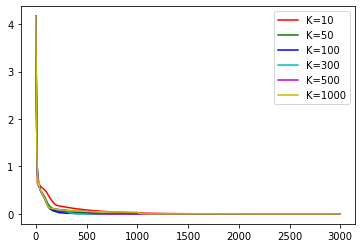

In [16]:
plt.plot(losses_1[:3000],'r', label = "K=10")
plt.plot(losses_2[:3000],'g', label = "K=50")
plt.plot(losses_3[:3000],'b', label = "K=100")
plt.plot(losses_4[:3000],'c', label = "K=300")
plt.plot(losses_5[:3000],'m', label = "K=500")
plt.plot(losses_6[:3000],'y', label = "K=1000")

plt.legend()
plt.show()

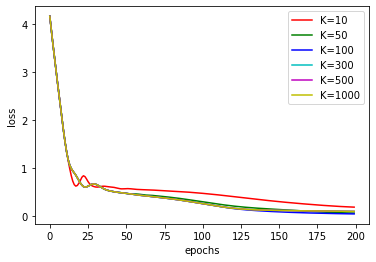

In [17]:
x_0_200 = np.arange(0,200)
plt.plot(x_0_200,losses_1[:200],'r', label = "K=10")
plt.plot(x_0_200,losses_2[:200],'g', label = "K=50")
plt.plot(x_0_200,losses_3[:200],'b', label = "K=100")
plt.plot(x_0_200,losses_4[:200],'c', label = "K=300")
plt.plot(x_0_200,losses_5[:200],'m', label = "K=500")
plt.plot(x_0_200,losses_6[:200],'y', label = "K=1000")

plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()

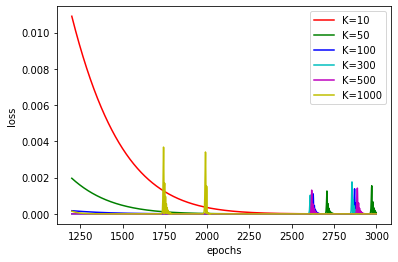

In [18]:
x_1500_3000 = np.arange(1200,3000)
plt.plot(x_1500_3000,losses_1[1200:3000],'r', label = "K=10")
plt.plot(x_1500_3000,losses_2[1200:3000],'g', label = "K=50")
plt.plot(x_1500_3000,losses_3[1200:3000],'b', label = "K=100")
plt.plot(x_1500_3000,losses_4[1200:3000],'c', label = "K=300")
plt.plot(x_1500_3000,losses_5[1200:3000],'m', label = "K=500")
plt.plot(x_1500_3000,losses_6[1200:3000],'y', label = "K=1000")

plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()

##Use smaller lr=0.005 and different K

###K=10

In [19]:
losses_7 = []
count = []
def main():
    model7 = test_Model(input_size).to(device)
    model7.train()
    non_symp_params, log_symp_params = get_parameters(model7)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=5e-3)

    for epoch in range(10000):
        preds = model7(torch.tensor(V).float())
        loss = model7.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        losses_7.append(loss)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))
        if loss <= 1e-8:
            count.append(epoch)
        #print(model7.symp.A)
        
    print("Optimization Finished!")
    model7.eval()
    print("The resulted symplectic matrix is:")
    print(model7.symp.A)
    print(count[0])


if __name__ == "__main__":
    main()

流式输出内容被截断，只能显示最后 5000 行内容。
Iter 5008: Loss= 0.013831
Iter 5009: Loss= 0.013814
Iter 5010: Loss= 0.013798
Iter 5011: Loss= 0.013782
Iter 5012: Loss= 0.013766
Iter 5013: Loss= 0.013750
Iter 5014: Loss= 0.013734
Iter 5015: Loss= 0.013717
Iter 5016: Loss= 0.013701
Iter 5017: Loss= 0.013685
Iter 5018: Loss= 0.013669
Iter 5019: Loss= 0.013653
Iter 5020: Loss= 0.013637
Iter 5021: Loss= 0.013621
Iter 5022: Loss= 0.013605
Iter 5023: Loss= 0.013589
Iter 5024: Loss= 0.013573
Iter 5025: Loss= 0.013557
Iter 5026: Loss= 0.013541
Iter 5027: Loss= 0.013525
Iter 5028: Loss= 0.013509
Iter 5029: Loss= 0.013493
Iter 5030: Loss= 0.013477
Iter 5031: Loss= 0.013461
Iter 5032: Loss= 0.013445
Iter 5033: Loss= 0.013429
Iter 5034: Loss= 0.013413
Iter 5035: Loss= 0.013397
Iter 5036: Loss= 0.013382
Iter 5037: Loss= 0.013366
Iter 5038: Loss= 0.013350
Iter 5039: Loss= 0.013334
Iter 5040: Loss= 0.013318
Iter 5041: Loss= 0.013302
Iter 5042: Loss= 0.013287
Iter 5043: Loss= 0.013271
Iter 5044: Loss= 0.013255
Iter 5045: 

###K=50

In [20]:
losses_8 =[]
count = []

def main():
    model8 = test_Model_2(input_size).to(device)
    model8.train()
    non_symp_params, log_symp_params = get_parameters(model8)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=5e-3)

    for epoch in range(10000):
        preds = model8(torch.tensor(V).float())
        loss = model8.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        losses_8.append(loss)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))
        #print(model8.symp.A)
        if loss <= 1e-8:
            count.append(epoch)
        
    print("Optimization Finished!")
    model8.eval()
    print("The resulted symplectic matrix is:")
    print(model8.symp.A)

    print(count[0])


if __name__ == "__main__":
    main()

流式输出内容被截断，只能显示最后 5000 行内容。
Iter 5008: Loss= 0.014224
Iter 5009: Loss= 0.014207
Iter 5010: Loss= 0.014191
Iter 5011: Loss= 0.014175
Iter 5012: Loss= 0.014158
Iter 5013: Loss= 0.014142
Iter 5014: Loss= 0.014126
Iter 5015: Loss= 0.014109
Iter 5016: Loss= 0.014093
Iter 5017: Loss= 0.014077
Iter 5018: Loss= 0.014061
Iter 5019: Loss= 0.014044
Iter 5020: Loss= 0.014028
Iter 5021: Loss= 0.014012
Iter 5022: Loss= 0.013996
Iter 5023: Loss= 0.013979
Iter 5024: Loss= 0.013963
Iter 5025: Loss= 0.013947
Iter 5026: Loss= 0.013931
Iter 5027: Loss= 0.013915
Iter 5028: Loss= 0.013899
Iter 5029: Loss= 0.013883
Iter 5030: Loss= 0.013866
Iter 5031: Loss= 0.013850
Iter 5032: Loss= 0.013834
Iter 5033: Loss= 0.013818
Iter 5034: Loss= 0.013802
Iter 5035: Loss= 0.013786
Iter 5036: Loss= 0.013770
Iter 5037: Loss= 0.013754
Iter 5038: Loss= 0.013738
Iter 5039: Loss= 0.013722
Iter 5040: Loss= 0.013706
Iter 5041: Loss= 0.013690
Iter 5042: Loss= 0.013674
Iter 5043: Loss= 0.013658
Iter 5044: Loss= 0.013642
Iter 5045: 

###K=100

In [21]:
losses_9 =[]
count = []

def main():
    model9 = test_Model_3(input_size).to(device)
    model9.train()
    non_symp_params, log_symp_params = get_parameters(model9)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=5e-3)

    for epoch in range(10000):
        preds = model9(torch.tensor(V).float())
        loss = model9.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        losses_9.append(loss)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))
        #print(model9.symp.A)
        if loss <= 1e-8:
            count.append(epoch)
        
    print("Optimization Finished!")
    model9.eval()
    print("The resulted symplectic matrix is:")
    print(model9.symp.A)
    print(count[0])


if __name__ == "__main__":
    main()

流式输出内容被截断，只能显示最后 5000 行内容。
Iter 5008: Loss= 0.015241
Iter 5009: Loss= 0.015224
Iter 5010: Loss= 0.015207
Iter 5011: Loss= 0.015190
Iter 5012: Loss= 0.015173
Iter 5013: Loss= 0.015156
Iter 5014: Loss= 0.015139
Iter 5015: Loss= 0.015122
Iter 5016: Loss= 0.015105
Iter 5017: Loss= 0.015088
Iter 5018: Loss= 0.015071
Iter 5019: Loss= 0.015054
Iter 5020: Loss= 0.015037
Iter 5021: Loss= 0.015020
Iter 5022: Loss= 0.015003
Iter 5023: Loss= 0.014986
Iter 5024: Loss= 0.014969
Iter 5025: Loss= 0.014952
Iter 5026: Loss= 0.014935
Iter 5027: Loss= 0.014918
Iter 5028: Loss= 0.014901
Iter 5029: Loss= 0.014885
Iter 5030: Loss= 0.014868
Iter 5031: Loss= 0.014851
Iter 5032: Loss= 0.014834
Iter 5033: Loss= 0.014817
Iter 5034: Loss= 0.014800
Iter 5035: Loss= 0.014784
Iter 5036: Loss= 0.014767
Iter 5037: Loss= 0.014750
Iter 5038: Loss= 0.014733
Iter 5039: Loss= 0.014717
Iter 5040: Loss= 0.014700
Iter 5041: Loss= 0.014683
Iter 5042: Loss= 0.014666
Iter 5043: Loss= 0.014650
Iter 5044: Loss= 0.014633
Iter 5045: 

###K=300

In [22]:
losses_10 =[]
count = []

def main():
    model10 = test_Model_4(input_size).to(device)
    model10.train()
    non_symp_params, log_symp_params = get_parameters(model10)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=5e-3)

    for epoch in range(10000):
        preds = model10(torch.tensor(V).float())
        loss = model10.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        losses_10.append(loss)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))
        #print(model10.symp.A)
        if loss <= 1e-8:
            count.append(epoch)
        
    print("Optimization Finished!")
    model10.eval()
    print("The resulted symplectic matrix is:")
    print(model10.symp.A)
    print(count[0])


if __name__ == "__main__":
    main()

流式输出内容被截断，只能显示最后 5000 行内容。
Iter 5008: Loss= 0.009157
Iter 5009: Loss= 0.009147
Iter 5010: Loss= 0.009136
Iter 5011: Loss= 0.009125
Iter 5012: Loss= 0.009115
Iter 5013: Loss= 0.009104
Iter 5014: Loss= 0.009093
Iter 5015: Loss= 0.009083
Iter 5016: Loss= 0.009072
Iter 5017: Loss= 0.009062
Iter 5018: Loss= 0.009051
Iter 5019: Loss= 0.009040
Iter 5020: Loss= 0.009030
Iter 5021: Loss= 0.009019
Iter 5022: Loss= 0.009009
Iter 5023: Loss= 0.008998
Iter 5024: Loss= 0.008988
Iter 5025: Loss= 0.008977
Iter 5026: Loss= 0.008966
Iter 5027: Loss= 0.008956
Iter 5028: Loss= 0.008945
Iter 5029: Loss= 0.008935
Iter 5030: Loss= 0.008924
Iter 5031: Loss= 0.008914
Iter 5032: Loss= 0.008903
Iter 5033: Loss= 0.008893
Iter 5034: Loss= 0.008882
Iter 5035: Loss= 0.008872
Iter 5036: Loss= 0.008862
Iter 5037: Loss= 0.008851
Iter 5038: Loss= 0.008841
Iter 5039: Loss= 0.008830
Iter 5040: Loss= 0.008820
Iter 5041: Loss= 0.008809
Iter 5042: Loss= 0.008799
Iter 5043: Loss= 0.008789
Iter 5044: Loss= 0.008778
Iter 5045: 

###K=500

In [23]:
losses_11 =[]
count = []

def main():
    model11 = test_Model_5(input_size).to(device)
    model11.train()
    non_symp_params, log_symp_params = get_parameters(model11)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=5e-3)

    for epoch in range(10000):
        preds = model11(torch.tensor(V).float())
        loss = model11.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        losses_11.append(loss)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))
        #print(model11.symp.A)
        if loss <= 1e-8:
            count.append(epoch)
        
    print("Optimization Finished!")
    model11.eval()
    print("The resulted symplectic matrix is:")
    print(model11.symp.A)
    print(count[0])


if __name__ == "__main__":
    main()

流式输出内容被截断，只能显示最后 5000 行内容。
Iter 5008: Loss= 0.004463
Iter 5009: Loss= 0.004458
Iter 5010: Loss= 0.004453
Iter 5011: Loss= 0.004447
Iter 5012: Loss= 0.004442
Iter 5013: Loss= 0.004437
Iter 5014: Loss= 0.004432
Iter 5015: Loss= 0.004427
Iter 5016: Loss= 0.004421
Iter 5017: Loss= 0.004416
Iter 5018: Loss= 0.004411
Iter 5019: Loss= 0.004406
Iter 5020: Loss= 0.004401
Iter 5021: Loss= 0.004396
Iter 5022: Loss= 0.004391
Iter 5023: Loss= 0.004386
Iter 5024: Loss= 0.004381
Iter 5025: Loss= 0.004375
Iter 5026: Loss= 0.004370
Iter 5027: Loss= 0.004365
Iter 5028: Loss= 0.004360
Iter 5029: Loss= 0.004355
Iter 5030: Loss= 0.004350
Iter 5031: Loss= 0.004345
Iter 5032: Loss= 0.004340
Iter 5033: Loss= 0.004335
Iter 5034: Loss= 0.004330
Iter 5035: Loss= 0.004325
Iter 5036: Loss= 0.004319
Iter 5037: Loss= 0.004314
Iter 5038: Loss= 0.004309
Iter 5039: Loss= 0.004304
Iter 5040: Loss= 0.004299
Iter 5041: Loss= 0.004294
Iter 5042: Loss= 0.004289
Iter 5043: Loss= 0.004284
Iter 5044: Loss= 0.004279
Iter 5045: 

###K=1000

In [24]:
losses_12 =[]
count =[]

def main():
    model12 = test_Model_6(input_size).to(device)
    model12.train()
    non_symp_params, log_symp_params = get_parameters(model12)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=5e-3)

    for epoch in range(10000):
        preds = model12(torch.tensor(V).float())
        loss = model12.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        losses_12.append(loss)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))
        #print(model12.symp.A)
        if loss <= 1e-8:
            count.append(epoch)
        
    print("Optimization Finished!")
    model12.eval()
    print("The resulted symplectic matrix is:")
    print(model12.symp.A)
    print(count[0])


if __name__ == "__main__":
    main()

流式输出内容被截断，只能显示最后 5000 行内容。
Iter 5008: Loss= 0.000495
Iter 5009: Loss= 0.000494
Iter 5010: Loss= 0.000494
Iter 5011: Loss= 0.000493
Iter 5012: Loss= 0.000493
Iter 5013: Loss= 0.000492
Iter 5014: Loss= 0.000492
Iter 5015: Loss= 0.000491
Iter 5016: Loss= 0.000490
Iter 5017: Loss= 0.000490
Iter 5018: Loss= 0.000489
Iter 5019: Loss= 0.000489
Iter 5020: Loss= 0.000488
Iter 5021: Loss= 0.000488
Iter 5022: Loss= 0.000487
Iter 5023: Loss= 0.000486
Iter 5024: Loss= 0.000486
Iter 5025: Loss= 0.000485
Iter 5026: Loss= 0.000485
Iter 5027: Loss= 0.000484
Iter 5028: Loss= 0.000484
Iter 5029: Loss= 0.000483
Iter 5030: Loss= 0.000483
Iter 5031: Loss= 0.000482
Iter 5032: Loss= 0.000481
Iter 5033: Loss= 0.000481
Iter 5034: Loss= 0.000480
Iter 5035: Loss= 0.000480
Iter 5036: Loss= 0.000479
Iter 5037: Loss= 0.000479
Iter 5038: Loss= 0.000478
Iter 5039: Loss= 0.000478
Iter 5040: Loss= 0.000477
Iter 5041: Loss= 0.000477
Iter 5042: Loss= 0.000476
Iter 5043: Loss= 0.000475
Iter 5044: Loss= 0.000475
Iter 5045: 

In [25]:
losses_13 =[]
count =[]

class test_Model_7(nn.Module):
    def __init__(self, input_size):
        super(test_Model_7, self).__init__()
        self.symp = LinearSymplectic(input_size, mode=("dynamic", 10000, 10000), param=param)
        #self.lin = nn.Linear(input_size, input_size)
        self.J = self.symp.J
        self.loss_func = nn.MSELoss()

    def forward(self, input): 
        l = self.symp(input)
        #l = self.lin(l)
        return l

    def loss(self, preds, y):
        return self.loss_func(preds, y)


def main():
    model13 = test_Model_7(input_size).to(device)
    model13.train()
    non_symp_params, log_symp_params = get_parameters(model13)
    #optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=5e-3)

    for epoch in range(10000):
        preds = model13(torch.tensor(V).float())
        loss = model13.loss(preds, torch.tensor(y).float())
        loss.backward()
        #if optim.step():
            #optim.step()
        if optim_symp:
            optim_symp.step()

        #if optim.zero_grad():
            #optim.zero_grad()
        if optim_symp:
            optim_symp.zero_grad()
        losses_13.append(loss)
        print("Iter {}: Loss= {:.6f}".format(epoch, loss))
        #print(model13.symp.A)
        if loss <= 1e-8:
            count.append(epoch)
        
    print("Optimization Finished!")
    model13.eval()
    print("The resulted symplectic matrix is:")
    print(model13.symp.A)


if __name__ == "__main__":
    main()

流式输出内容被截断，只能显示最后 5000 行内容。
Iter 5006: Loss= 0.035641
Iter 5007: Loss= 0.035636
Iter 5008: Loss= 0.035631
Iter 5009: Loss= 0.035626
Iter 5010: Loss= 0.035620
Iter 5011: Loss= 0.035615
Iter 5012: Loss= 0.035610
Iter 5013: Loss= 0.035605
Iter 5014: Loss= 0.035600
Iter 5015: Loss= 0.035594
Iter 5016: Loss= 0.035589
Iter 5017: Loss= 0.035584
Iter 5018: Loss= 0.035579
Iter 5019: Loss= 0.035574
Iter 5020: Loss= 0.035569
Iter 5021: Loss= 0.035563
Iter 5022: Loss= 0.035558
Iter 5023: Loss= 0.035553
Iter 5024: Loss= 0.035548
Iter 5025: Loss= 0.035543
Iter 5026: Loss= 0.035538
Iter 5027: Loss= 0.035532
Iter 5028: Loss= 0.035527
Iter 5029: Loss= 0.035522
Iter 5030: Loss= 0.035517
Iter 5031: Loss= 0.035512
Iter 5032: Loss= 0.035507
Iter 5033: Loss= 0.035502
Iter 5034: Loss= 0.035496
Iter 5035: Loss= 0.035491
Iter 5036: Loss= 0.035486
Iter 5037: Loss= 0.035481
Iter 5038: Loss= 0.035476
Iter 5039: Loss= 0.035471
Iter 5040: Loss= 0.035466
Iter 5041: Loss= 0.035461
Iter 5042: Loss= 0.035455
Iter 5043: 

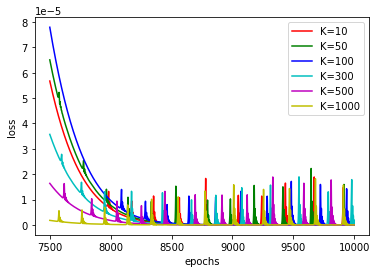

In [26]:
x_7500_10000 = np.arange(7500,10000)
plt.plot(x_7500_10000,losses_7[7500:10000],'r', label = "K=10")
plt.plot(x_7500_10000,losses_8[7500:10000],'g', label = "K=50")
plt.plot(x_7500_10000,losses_9[7500:10000],'b', label = "K=100")
plt.plot(x_7500_10000,losses_10[7500:10000],'c', label = "K=300")
plt.plot(x_7500_10000,losses_11[7500:10000],'m', label = "K=500")
plt.plot(x_7500_10000,losses_12[7500:10000],'y', label = "K=1000")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

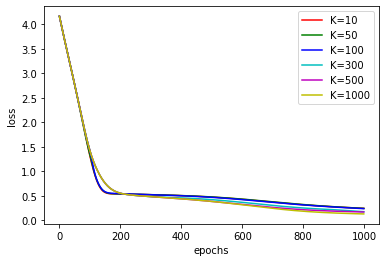

In [27]:
x_200 = np.arange(0,1000)
plt.plot(x_200,losses_7[0:1000],'r', label = "K=10")
plt.plot(x_200,losses_8[0:1000],'g', label = "K=50")
plt.plot(x_200,losses_9[0:1000],'b', label = "K=100")
plt.plot(x_200,losses_10[0:1000],'c', label = "K=300")
plt.plot(x_200,losses_11[0:1000],'m', label = "K=500")
plt.plot(x_200,losses_12[0:1000],'y', label = "K=1000")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

#Mini Batch

In [28]:
minibatch_losses = []
count = []
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

data = TensorDataset(torch.tensor(V).float(),torch.tensor(y).float())
dataloader =  DataLoader(data,batch_size = 32, shuffle=True)

def main(train_dl, loss_func=nn.MSELoss()):
    model = test_Model(input_size).to(device)
    model.train()

    non_symp_params, log_symp_params = get_parameters(model)
    # optim = torch.optim.Adam(non_symp_params, args.lr)
    optim_symp = torch.optim.Adam(log_symp_params, lr=5e-3)

    # using decreasing learning rate lr=lr*0.997**epoch
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim_symp, gamma=0.997)

    for epoch in range(epochs2):
        train_losses = []
        for step, (x, y) in enumerate(train_dl):

            prediction = model(x.to(device))

            loss = loss_func(prediction, y.to(device))
            loss.backward()

            #optim.step()
            if optim_symp:
                optim_symp.step()

            #optim.zero_grad()
            if optim_symp:
                optim_symp.zero_grad()
            train_losses.append(loss.item())

        scheduler.step()
        minibatch_losses.append(np.mean(train_losses))
        print("Iter {}: Loss= {:.6f}".format(epoch, np.mean(train_losses)))
        #print(model.symp.A)
        if loss <= 1e-8:
            count.append(epoch)

    print("Optimization Finished!")
    model.eval()
    print(model.symp.A)
    print(count[0])

main(dataloader)

Iter 0: Loss= 3.738325
Iter 1: Loss= 2.871314
Iter 2: Loss= 1.941176
Iter 3: Loss= 1.085978
Iter 4: Loss= 0.623099
Iter 5: Loss= 0.543953
Iter 6: Loss= 0.537986
Iter 7: Loss= 0.533090
Iter 8: Loss= 0.529444
Iter 9: Loss= 0.527538
Iter 10: Loss= 0.520116
Iter 11: Loss= 0.519687
Iter 12: Loss= 0.507546
Iter 13: Loss= 0.509234
Iter 14: Loss= 0.497934
Iter 15: Loss= 0.493083
Iter 16: Loss= 0.486709
Iter 17: Loss= 0.487547
Iter 18: Loss= 0.480351
Iter 19: Loss= 0.470590
Iter 20: Loss= 0.463319
Iter 21: Loss= 0.442978
Iter 22: Loss= 0.432002
Iter 23: Loss= 0.424984
Iter 24: Loss= 0.409647
Iter 25: Loss= 0.395880
Iter 26: Loss= 0.384188
Iter 27: Loss= 0.374071
Iter 28: Loss= 0.367828
Iter 29: Loss= 0.356741
Iter 30: Loss= 0.341195
Iter 31: Loss= 0.334838
Iter 32: Loss= 0.325235
Iter 33: Loss= 0.320529
Iter 34: Loss= 0.309308
Iter 35: Loss= 0.304552
Iter 36: Loss= 0.294478
Iter 37: Loss= 0.284512
Iter 38: Loss= 0.282116
Iter 39: Loss= 0.277119
Iter 40: Loss= 0.270357
Iter 41: Loss= 0.263615
It

##Comparison between Vanilla and MiniBatch

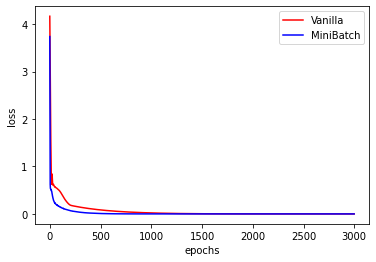

In [29]:
x_0_300 = np.arange(0,3000)
plt.plot(losses_1[0:3000], 'r', label="Vanilla")
plt.plot(minibatch_losses[0:3000], 'b', label='MiniBatch')

plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()

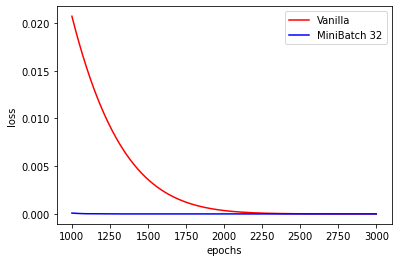

In [30]:
x_1000_3000 = np.arange(1000,3000)
plt.plot(x_1000_3000, losses_1[1000:3000], 'r', label='Vanilla')
plt.plot(x_1000_3000, minibatch_losses[1000:3000], 'b', label='MiniBatch 32')


plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()